# Earth's Greenhouse Effect and Climate Sensitivity

This is a notebook I use to develop and present ideas for the Winter 2021/22 Semester graduate course I am teaching at the University of Hamburg.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import seaborn as sns
%matplotlib inline

## 1. Definitions

Define some constants and functions, to be used later in the notebook.  Notably the Planck source function the transmissivity and the flux transmissivity.

In [27]:
#
# Definition of basic physical constants
#
h     = 6.62607015e-34
c     = 299792458.0
kB     = 1.38064852e-23
sigma = 2*(np.pi**5) * kB**4 / (15 * h**3 * c**2)
N_avo = 6.02214076e+23
Rstar = kB*N_avo
g     = 9.81

#
#------------------------------------------------------------------
#
# typical concentrations of trace gasses
#
x_ar  = 9.332e-3
x_o2  = 0.20944
x_n2  = 0.78083
x_co2 = 415.e-6
x_ch4 = 772.e-9
x_n2o = 334.e-9
x_o3  = 200.e-9
#
#------------------------------------------------------------------
#
# molar masses in g/mol of different elements and molecules
#
m_h = 1.00784
m_c = 12.0107
m_n = 14.0067
m_o = 15.9994
m_ar= 39.948
m_n2  = 2*m_n
m_o2  = 2*m_o
m_o3  = 3*m_o
m_co2 = m_c   + m_o2
m_h2o = m_o   + 2*m_h
m_ch4 = m_c   + 4*m_h
m_n2o = 2*m_n + m_o
#
#------------------------------------------------------------------
#
# dry air molar masses and gas constants
#
m_dry = x_ar*m_ar + x_o2*m_o2 + x_n2*m_n2 + x_co2*m_co2
Rd    = (Rstar/m_dry)*(x_ar+x_o2+x_n2+x_co2) * 1000.  #J/kg/K

def Planck_s(T,nu):
    '''returns the planck source function for the given temperature and frequency'''
    h = 6.62607015e-34
    c = 299792458
    k = 1.380649e-23

    return (2 * h * nu**3 / c**2) / (np.exp(h*nu/(k*T))-1)

Planck = np.vectorize(Planck_s)

def Transmissivity(t1,t2):
    '''returns the transmissivity of the spectral intensity'''
    return np.exp(-(t2-t1))

Transmissivity_f = np.vectorize(Transmissivity)

def Tf(t1,t2,dmu=0.01):
    '''returns twice the integral of flux over cosine of zenith angles (mu = cos(theta)), which defines the tranmissivity of the flux'''
    mu  = np.arange(0,1,dmu) + dmu/2.
    return 2 * np.sum(Transmissivity(t1/mu,t2/mu) * mu * dmu)

Tf_v = np.vectorize(Tf)

### Flux transmissivity

Plot the diffusivity factor $r$ that must multiply the optical depth in the intensity transmissivity to yield the same value as the flux transmissivity.

Here we solve for the value of $r$ such that that $$e^{-r\tau} = \int_0^{1} e^{-\frac{\tau}{\mu}} \mu \mathrm{d}\mu$$ and show that in general its value depends on $\tau.$


mean (over tau = 0.0 to 5.0) diffusivity factor 1.416


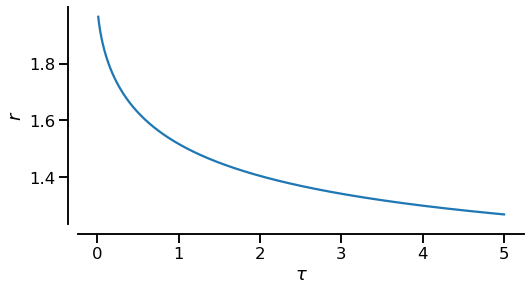

In [28]:
#
# set the spectral density, here working in  wavenumbers ranging rom 0.01 to 50000 cm-1
# and using this to set the wavelenths (lambda) in meters and frequencies nu in herz
#
k = np.arange(0.01,50000)
lmbd = 1/ (k*100)
nu   = c / lmbd
dnu  = nu[1]-nu[0]# plot the diffusivity factor for different optical depth
#
taus = np.arange(0.01,5,0.001)

xtau = -np.log(Tf_v(0,taus))/taus

sns.set_context('talk')
fig, ax = plt.subplots(1,1, sharey=True, figsize = (8,4))
ax.set_ylabel('$r$')
ax.set_xlabel('$\\tau$')

ax.plot(taus,xtau)
sns.despine(offset=10)

print ('mean (over tau = %.1f to %.1f) diffusivity factor %.3f'%(np.min(taus),np.max(taus),np.mean(xtau)))

### Planck source function

Net Emission at 255.0 K from Stefan Boltzmann = 239.76 W/m2 and Integrated Planck Function 239.76 W/m2
Net Emission at 303.0 K from Stefan Boltzmann = 477.95 W/m2 and Integrated Planck Function 477.95 W/m2


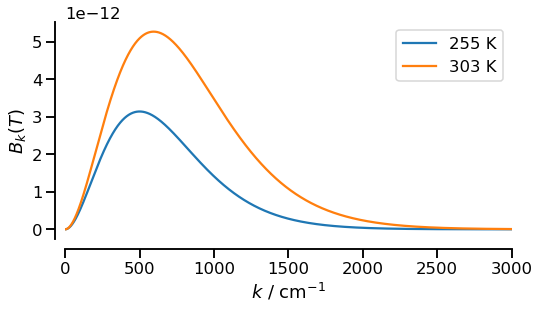

In [29]:
sns.set_context('talk')
fig, ax = plt.subplots(1,1, sharey=True, figsize = (8,4))

sns.set_context('talk')

for TK in [255,303]:
    ax.plot(k,Planck(TK,nu),label='%i K'%TK)
    print ('Net Emission at %.1f K from Stefan Boltzmann = %.2f W/m2 and Integrated Planck Function %.2f W/m2'%(TK,sigma*TK**4,np.sum(Planck(TK,nu)*dnu)*np.pi))

ax.set_ylabel('$B_k(T)$')
ax.set_xlabel('$k$ / cm$^{-1}$')
#ax.set_ylim(0.8,1.2)
#ax.set_yticks([0.8,np.round(y[-1],2),1.2])
#ax.set_yticks(np.arange(0.8,1.3,0.1),minor=True)
ax.set_xlim(0,3000)

plt.legend()
sns.despine(offset=10)


## 2. Emission height

In these code snippits we calculate the emission height for two different examples.  

In the first we calculate the flux at the top of the atmosphere assuming an atmosphere with a fixed lapse rate, of temperature in terms of optical depth, i.e., we model the atmospheric temperature as $$ T = T_s - G\tau.$$  Based on this temperature profile we calclate the at the top of the atmosphere as $$ F = \sigma T_s^4  e^{-\tau} + \int_0^\tau \sigma T(\tau')^4 \mathcal{T} e^{-(\tau - \tau')} \mathrm{d} \tau.$$   This is not particularly accurate as it uses the intensity transmissivity for the broadband flux, but because $r\approx 1$ it should be adequate to define the flux at the top of the atmosphere.  The temperature that would radiate this amount of flux is then calculated and the optical depth at which this temperature locates is compared to the total optical depth of the atmosphere.  THe difference between the two is shown to be approximately unity.

In the second we define an atmosphere whose temperature decreases linearly with height, so that $T = T_\mathrm{sfc} - \gamma z.$  Based on $(T,z)$ we calculate the pressure, $P,$ and density, $\rho$ both at points (heights) where the T locates (mid points, subscript $m$) and at the cell interfaces, assuming temperature locates at the cell center.   Given pressure and temperture calculate the optical depth for CO2 and for water vapor, assuming the latter is distributed with an RH-0.5.  Based on this plot the
* Consider playing with this example to vary the relationship between temperature and optical depth, does the rule of thumb hold well for all cases? 

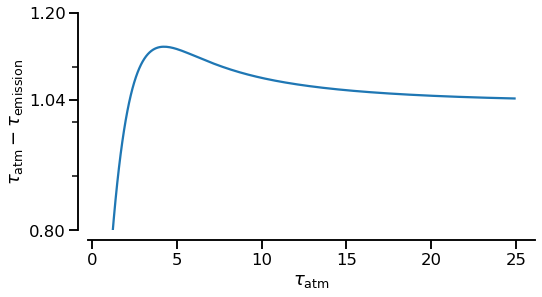

In [30]:
dtau = 0.001
tau_max = np.arange(1,25,0.1)
y       = np.zeros(len(tau_max))

Ts = 300.
for i,taux in enumerate(tau_max):
    tau = np.arange(dtau/2.,taux+dtau/2.,dtau)
    G   = 100./taux

    Ta  = Ts - G*(tau)
    Fb  = (sigma * Ts**4 + np.sum(sigma*Ta**4 * np.exp(tau) * dtau))* np.exp(-taux)
    Tb  = (Fb/sigma)**0.25
    y[i] = (Tb - np.min(Ta))/G

sns.set_context('talk')
fig, ax = plt.subplots(1,1, sharey=True, figsize = (8,4))

sns.set_context('talk')
ax.plot(tau_max,y)
ax.set_xlabel('$\\tau_\mathrm{atm}$')
ax.set_ylabel('$\\tau_\mathrm{atm} - \\tau_\mathrm{emission}$')
ax.set_ylim(0.8,1.2)
ax.set_yticks([0.8,np.round(y[-1],2),1.2])
ax.set_yticks(np.arange(0.8,1.3,0.1),minor=True)
sns.despine (offset=10)


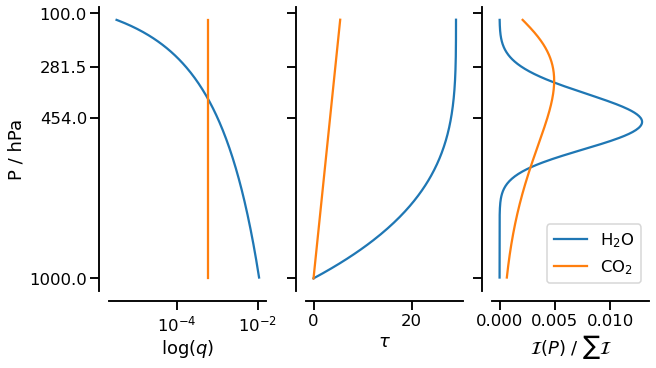

In [31]:
npts  = 300
gamma =7e-3

Z  = np.linspace(0,15000.,npts+1)
Zm = 0.5*(Z[1:]+Z[0:-1])
T  = Tsfc - gamma * Zm
dZ = np.diff(Z)

P = np.zeros(len(Z))
P[0] = 10**5

for i in np.arange(1,len(P)):
    P[i] = P[i-1] * np.exp(-g/(Rd*T[i-1])*dZ[i-1])

Pm      = np.exp((np.log(P[1:]) + np.log(P[0:-1]))*0.5 )
rho     = Pm/(Rd*T) 

q_co2    = 400e-6 * (m_co2/m_dry)*np.ones(len(T))
dtau_co2 = rho*q_co2*dZ
tau_co2  = np.zeros(len(dtau_co2)+1)
tau_co2[1:]  = np.cumsum(dtau_co2)
q_h2o    = 0.5*(611*np.exp(17.27*(T-273.15)/(237.3 + T - 273.15))/Pm)*(m_h2o/m_dry)
dtau_h2o = rho*q_h2o*dZ
tau_h2o  = np.zeros(len(dtau_h2o)+1)
tau_h2o[1:]  = np.cumsum(dtau_h2o)

p1_co2 = np.max(P[tau_co2+1 > np.max(tau_co2)])
p1_h2o = np.max(P[tau_h2o+1 > np.max(tau_h2o)])

nu = c/10e-6
I_co2 = Planck(T,nu) * dtau_co2 * transmissivity(tau_co2[1:],tau_co2[-1])
I_h2o = Planck(T,nu) * dtau_h2o * transmissivity(tau_h2o[1:],tau_h2o[-1])

I_co2 = (I_co2/np.sum(I_co2))
I_h2o = (I_h2o/np.sum(I_h2o))
sns.set_context('talk')

fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True, figsize = (9,5), constrained_layout = True)

ax1.semilogx(q_h2o,Pm/100.)
ax1.semilogx(q_co2,Pm/100.)
ax2.plot(tau_h2o,P/100.)
ax2.plot(tau_co2,P/100.)
ax3.plot(I_h2o,Pm/100.,label='H$_2$O')
ax3.plot(I_co2,Pm/100.,label='CO$_2$')
ax1.set_ylabel('P / hPa')
ax1.set_xlabel('$\log(q)$')
ax2.set_xlabel('$\\tau$')
ax3.set_xlabel('$\mathcal{I}(P)$ / $\sum \mathcal{I}$')

ax1.set_yticks(np.asarray([10000,p1_co2,p1_h2o,100000])/100.)
plt.gca().invert_yaxis()

plt.legend()
sns.despine(offset=10)

fig.savefig('emission-height.pdf')